## Will work in the flux basis with the Hamiltonian:
## $$ H = 0.05 n_q^2 - \frac{1}{\frac12 + \alpha(t)} \cos(\phi) +  \alpha(t) \cos(2\phi -0.1\pi)$$
## With $\alpha \in [0;1]$

## This looks like:

In [68]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt

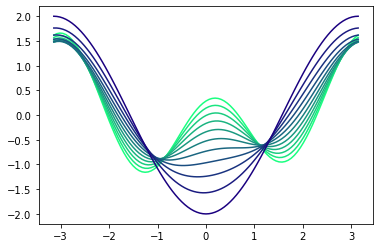

In [331]:
N = 101
phi = t.linspace(-np.pi,np.pi,N)
dphi = (phi[1:] - phi[:-1]).mean().item()

def V(phi,alpha=1):
    return -1/(0.5+alpha)*t.cos(phi) + alpha*t.cos(2*phi - 0.1*np.pi)

fig, ax = plt.subplots()
for alpha in np.arange(1,-0.1,-0.1):
    ax.plot(phi,V(phi,alpha),c=(0.1,alpha,0.5))

In [152]:
class System(t.nn.Module):
    def __init__(self, phi, T, NTrot): #phi is not used?
        super(System,self).__init__()
        self.prepare_KinE()
        self.T = T
        self.NTrot = NTrot
        
        self.times = t.linspace(0,T,self.NTrot)
        self.dt = (self.times[1:] - self.times[:-1]).mean().item()
        self.Id = t.diag(t.ones(self.Kinetic_energy.shape[0],dtype=t.complex128))
        
        self.decline_end = t.nn.parameter.Parameter(t.tensor(0.5*self.T))
        self.ascend_start = t.nn.parameter.Parameter(t.tensor(0.5*self.T))
        self.ReLU = t.nn.ReLU()
        self.Sigmoid = t.nn.Sigmoid()
        self.steep_factor = 10
        
        
    def forward(self):
        H = self.Kinetic_energy.repeat((self.NTrot,1,1)) \
            + t.diag_embed(V(phi.unsqueeze(0),self.activation_func(self.times).unsqueeze(1))).type(t.complex128)
        return t.linalg.multi_dot([mat for mat in t.matrix_exp(-1j*H*self.dt)])

    def activation_func(self,time):
        decline_end = self.restrict_time(self.decline_end)
        ascend_start = self.restrict_time(self.ascend_start)

        left_slope = self.ReLU(decline_end - time)/decline_end
        right_slope = self.ReLU(time - ascend_start)/(self.T - ascend_start)
        return left_slope + right_slope #Perhaps implement something with max?

    def restrict_time(self,time_point):
        return self.Sigmoid(self.steep_factor*time_point)*self.Sigmoid(self.steep_factor*(self.T - time_point))*time_point + self.Sigmoid(self.steep_factor*(time_point - self.T))*self.T
    
    def prepare_KinE(self):
        double_diff = (t.diag(-2*t.ones(N)) + t.diag(t.ones(N-1),1) + t.diag(t.ones(N-1),-1)).type(t.complex128)
        dphi = (phi[1:] - phi[:-1]).mean().item()
        self.Kinetic_energy = -0.05/dphi**2*double_diff
        return
    
    def plot_activation_func(self):
        plt.plot(self.times,self.activation_func(self.times).detach(),'b.')
        plt.ylim(0,None)
        return

    # def get_H(self,alpha=1):
    #     return self.Kinetic_energy + t.diag(V(phi,alpha)).type(t.complex128)

In [154]:
model = System(phi,30,201)
optimizer = t.optim.Adam(model.parameters(),lr=1e-1)

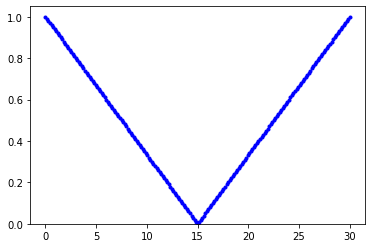

In [155]:
model.plot_activation_func()

In [332]:
H = model.Kinetic_energy + t.diag(V(phi))
eigvals, eigvecs = t.linalg.eigh(H)
eigvecs = eigvecs.T

c:\Users\jv97\anaconda3\envs\myenv\lib\site-packages\matplotlib\axes\_axes.py:5363: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
c:\Users\jv97\anaconda3\envs\myenv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


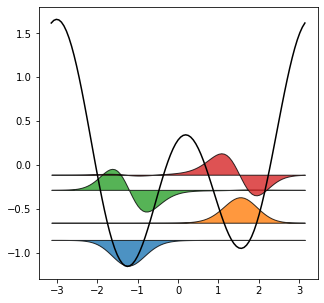

In [333]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(phi,V(phi),'k')
indices = [0,1,2,3]
for i in indices:
    ax.fill_between(phi,eigvecs[i]+eigvals[i],[eigvals[i] for _ in phi],label='n=%d'%i,edgecolor='k',alpha=0.8)

In [158]:
def loss_func(U):
    return 1 - t.abs(eigvecs[1]@U@eigvecs[0])**2

def epoch(threshold, N_max):
    from time import time
    optimizer.zero_grad()
    loss = loss_func(model())
    loss.backward()
    optimizer.step()

    print(f"initial loss: {loss.item()}")

    N = 1

    start_time = time()
    while loss >= threshold and N <= N_max:
        optimizer.zero_grad()
        loss = loss_func(model())
        loss.backward()
        optimizer.step()
        N += 1
        print(f"loss: {loss.item()}, step: {N}", end='\r')
    print(f"Ended at step: {N}, with loss: {loss.item()} and runtime: {time() - start_time}")

In [159]:
epoch(0.1,100)

initial loss: 0.6172267069671986
Ended at step: 101, with loss: 0.2014797543076038 and runtime: 373.5595602989197


In [161]:
epoch(0.1,100)

initial loss: 0.19996564726470134
Ended at step: 83, with loss: 0.09980124440952787 and runtime: 286.3058521747589


In [163]:
epoch(0.01,100)

initial loss: 0.09919703491425591
Ended at step: 101, with loss: 0.08349275399759482 and runtime: 328.6406989097595


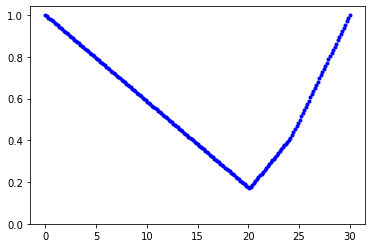

In [334]:
model.plot_activation_func()

In [167]:
U = model().detach()

c:\Users\jv97\anaconda3\envs\myenv\lib\site-packages\matplotlib\axes\_axes.py:5363: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
c:\Users\jv97\anaconda3\envs\myenv\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


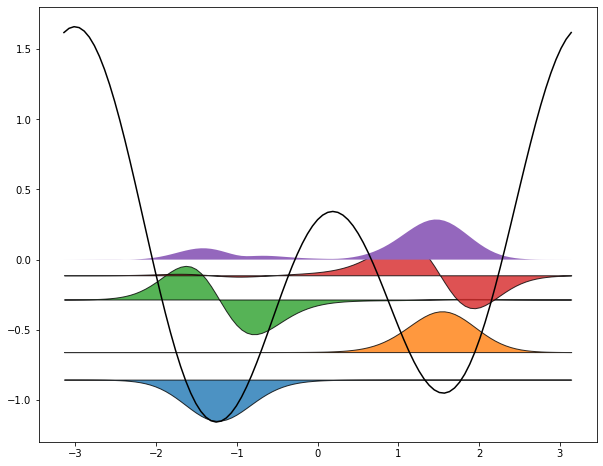

In [186]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(phi,V(phi),'k')
indices = [0,1,2,3]
for i in indices:
    ax.fill_between(phi,eigvecs[i]+eigvals[i],eigvals[i],label='n=%d'%i,edgecolor='k',alpha=0.8)

ax.fill_between(phi,t.abs(U0@U@eigvecs[0]),0)

In [309]:
def animate_run(self=model, init_wavefunc=eigvecs[0]):
    alphas = t.cat([t.ones(self.times.shape[0]),self.activation_func(self.times).detach()]).flip(0)
    wavefuncs = t.zeros((alphas.shape[0]+1,N)).type(t.complex128)
    
    H = self.Kinetic_energy.repeat((alphas.shape[0],1,1)) \
        + t.diag_embed(V(phi.unsqueeze(0),alphas.unsqueeze(1))).type(t.complex128)
    exp_H = t.matrix_exp(-1j*H*self.dt)
    wavefuncs[0] = init_wavefunc
    for i, mat in enumerate(exp_H):
        wavefuncs[i+1] = mat@wavefuncs[i]

    wavefuncs = t.abs(wavefuncs)

    from IPython.display import clear_output, display
    from time import sleep
    fig, ax = plt.subplots(figsize=(10,5),ncols=2)
    # hdisplay = display("", display_id=True)
    
    potential, = ax[0].plot(phi,V(phi),'k')
    state, = ax[0].plot(phi,wavefuncs[0])
    ax[0].hlines(0,phi.min(),phi.max())
    ax[1].plot(np.linspace(0,self.T*2,alphas.shape[0]),alphas)
    vline = ax[1].vlines(0,0,1,color='k',linestyle='--')
    for i, wavefunc in enumerate(wavefuncs[1:]):
        potential.set_ydata(V(phi,alphas[i]))
        state.set_ydata(wavefunc)
        vline.set_offsets((240*i/alphas.shape[0],0))

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)        
    return


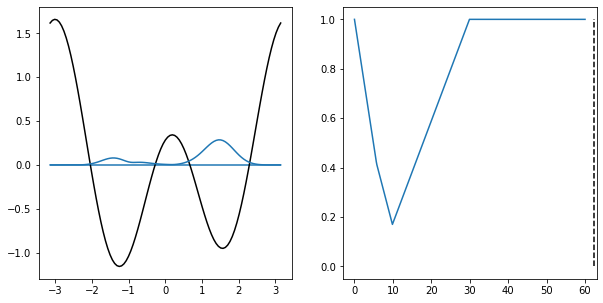

In [335]:
animate_run()

In [194]:
U0 = t.matrix_power(t.matrix_exp(-1j*H*model.T/5000),5000)

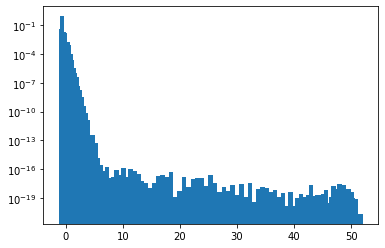

In [181]:
plt.bar(eigvals,t.abs(eigvecs@U@eigvecs[0])**2,linewidth=0.01)
# plt.xscale('log')
plt.yscale('log')